# Final dataset preparation

## Imports and data read

In [309]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from openai import OpenAI
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

from utilities.useful_functions import extract_website_name, create_boxplot, create_wordcloud, detect_language_safe, count_emojis, count_special_characters

In [ ]:
# import datetime
# import json

In [310]:
ru_stopwords = pd.read_csv('ru_stopwords.csv')

In [311]:
ua_stopwords = pd.read_csv('ua_stopwords.csv')

In [2]:
# this one is prepared in 'Concatentation of explored datasets.ipynb' and annotated using Telegram bot
path = './data_provided/final_dataset/final_preprocessed_07042025.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
del df['Unnamed: 0']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13012 entries, 0 to 13011
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   response_id          13012 non-null  int64 
 1   document_id          13012 non-null  int64 
 2   user_id              13012 non-null  int64 
 3   annotator_sentiment  13012 non-null  object
 4   is_ck_annotation     13012 non-null  int64 
 5   response_timestamp   13012 non-null  object
 6   document_content     13012 non-null  object
 7   annotation_date      13012 non-null  object
 8   username             13012 non-null  object
dtypes: int64(4), object(5)
memory usage: 915.0+ KB


In [6]:
df.head()

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O
1,2,1,1065283664,neutral,1,2025-03-09T23:42:44.339410,⚡️Українська делегація відправилася на перемов...,2025-03-09,A
2,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A
3,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A
4,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A


In [7]:
df.document_id.nunique()

12586

In [8]:
df.annotator_sentiment.unique()

array(['neutral', 'negative', 'positive', 'mixed', 'idk'], dtype=object)

In [9]:
df.username.unique()

array(['O', 'A', 'V', 'D', 'S'], dtype=object)

## 1. Inter-annotator agreement review | Cohen’s Kappa Statistic

#### (1.1) Visual review of mutual annotations

In [10]:
cohens_set = df.loc[(df['is_ck_annotation'] == 1), ['document_id', 'document_content']]

In [11]:
cohens_set = cohens_set.groupby('document_id').agg({'document_content': 'first'}).reset_index()

In [12]:
cohens_set

,document_id,document_content
0,1,⚡️Українська делегація відправилася на перемов...
1,2,"Вибухи на Одещині, попередньо — ППО."
2,3,"А что делать тем ,кто лишился своего жилья ,по..."
3,4,Тогда учись быстро бегать. Для меня вопрос сло...
4,5,Добрий день
...,...,...
96,97,Спасибо за интересный обзор!
97,98,Зеленський підтримав приєднання України до іні...
98,99,Ой... в Білгороді зникло світло через пошкодже...
99,100,"Окупований Крим, орки почали копати нові окопи..."


In [13]:
for annotator in df.username.unique():
    cohens_temp = df.loc[(df['username'] == annotator) & (df['is_ck_annotation'] == 1), ['document_id', 'annotator_sentiment']]
    cohens_temp.columns = ['document_id', f'{annotator}_annotator_sentiment']

    cohens_set = cohens_set.merge(cohens_temp, how='left', on='document_id')

In [14]:
cohens_set.head(50)

,document_id,document_content,O_annotator_sentiment,A_annotator_sentiment,V_annotator_sentiment,D_annotator_sentiment,S_annotator_sentiment
0,1,⚡️Українська делегація відправилася на перемов...,neutral,neutral,neutral,neutral,neutral
1,2,"Вибухи на Одещині, попередньо — ППО.",neutral,neutral,neutral,neutral,neutral
2,3,"А что делать тем ,кто лишился своего жилья ,по...",negative,negative,negative,negative,negative
3,4,Тогда учись быстро бегать. Для меня вопрос сло...,negative,negative,negative,mixed,negative
4,5,Добрий день,neutral,neutral,neutral,neutral,neutral
5,6,"Бажаю удачі тим, хто цього потребує.",positive,positive,positive,positive,positive
6,7,Під Бахмутом українські військові просунулися ...,neutral,neutral,neutral,positive,positive
7,8,По какой схеме компенсируют? Может и мне за ...,neutral,neutral,neutral,neutral,neutral
8,9,Це ж Рищук !!! Це на нього схоже !!! Колись ві...,negative,negative,negative,negative,negative
9,10,А ещё открыта регистрация?,neutral,neutral,neutral,neutral,neutral


In [15]:
cohens_set.tail(50)

,document_id,document_content,O_annotator_sentiment,A_annotator_sentiment,V_annotator_sentiment,D_annotator_sentiment,S_annotator_sentiment
51,52,"Ніхто не має права вимагати щось від людини, я...",negative,negative,negative,negative,negative
52,53,"Доброго дня! Підкажіть, будь ласка, чи має пра...",neutral,neutral,neutral,neutral,neutral
53,54,"По кишенях?? Молодці , сідайте , вам 12 балів ...",positive,positive,mixed,positive,negative
54,55,є за шо,negative,negative,negative,negative,negative
55,56,Верно. Интернет провайдеров всех!!! Моего нет....,negative,negative,negative,negative,negative
56,57,Канада надасть Україні обладнання для розмінув...,neutral,neutral,neutral,neutral,neutral
57,58,Копійками та з податками?,neutral,neutral,neutral,neutral,neutral
58,59,Мені хоча б 50к свою стареньку мазанку підламп...,negative,negative,negative,negative,negative
59,60,Так щоб там щось з`явилось вам потрібно вимкну...,neutral,neutral,neutral,neutral,neutral
60,61,Харьков. Какое лицемерие. Забыли упомянуть как...,negative,negative,negative,negative,negative


Let's calculate the Cohen's Kappa scores for all pairs of annotators

In [16]:
annotators = df['username'].unique()
kappa_results = {}

for annotator1, annotator2 in itertools.combinations(annotators, 2):

    kappa = cohen_kappa_score(
        cohens_set[f'{annotator1}_annotator_sentiment'],
        cohens_set[f'{annotator2}_annotator_sentiment']
    )
    
    kappa_results[(annotator1, annotator2)] = kappa

In [17]:
def create_kappa_matrix(kappa_results, annotators):
    """Create a matrix of kappa scores between all annotators"""
    n = len(annotators)
    matrix = np.zeros((n, n))
    
    annotator_to_idx = {annotator: i for i, annotator in enumerate(annotators)}
    
    for (ann1, ann2), result in kappa_results.items():
        i, j = annotator_to_idx[ann1], annotator_to_idx[ann2]
        matrix[i, j] = result
        matrix[j, i] = result
    
    np.fill_diagonal(matrix, 1.0)
    
    return pd.DataFrame(matrix, index=annotators, columns=annotators)

In [18]:
def plot_kappa_heatmap(kappa_df):
    """Plot a heatmap of kappa scores"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(kappa_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Cohen's Kappa Inter-Annotator Agreement")
    plt.tight_layout()
    plt.show()

In [19]:
kappa_matrix = create_kappa_matrix(kappa_results, annotators)

In [20]:
kappa_matrix

,O,A,V,D,S
O,1.000000,0.864186,0.816974,0.838939,0.788703
A,0.864186,1.000000,0.802170,0.809655,0.713454
V,0.816974,0.802170,1.000000,0.749708,0.771837
D,0.838939,0.809655,0.749708,1.000000,0.766034
S,0.788703,0.713454,0.771837,0.766034,1.000000


In [21]:
df.username.value_counts()

username
D    7267
O    4102
V    1037
A     391
S     215
Name: count, dtype: int64

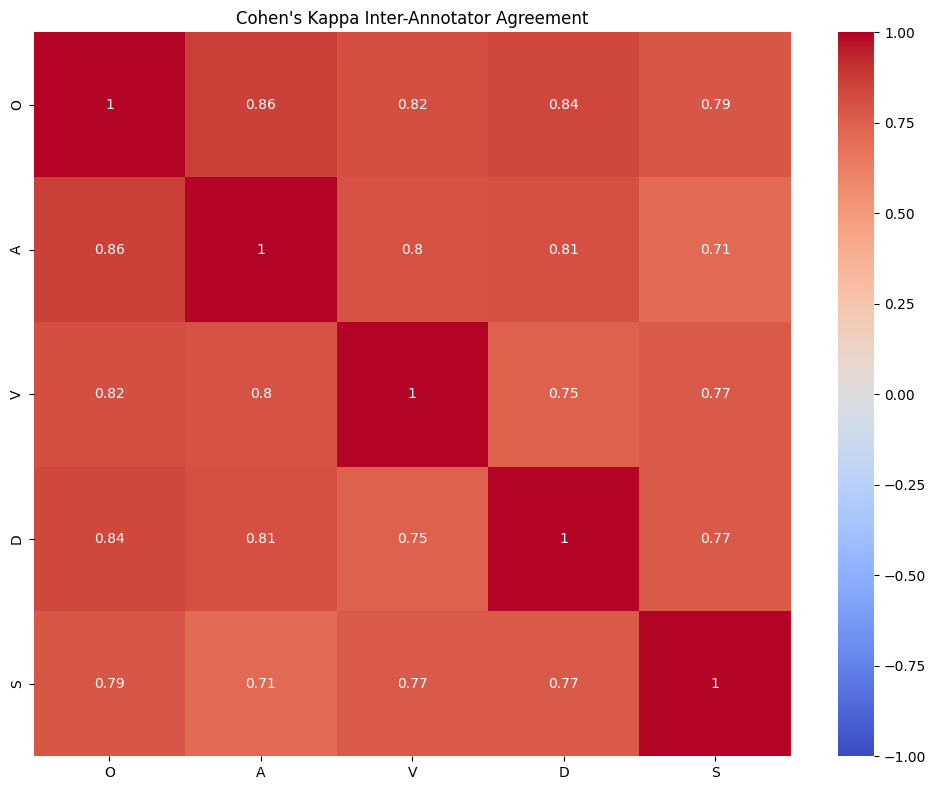

In [22]:
plot_kappa_heatmap(kappa_matrix)

Cohen's Kappa score scale according to 

https://pmc.ncbi.nlm.nih.gov/articles/PMC3900052/#:~:text=Cohen%20suggested%20the%20Kappa%20result,1.00%20as%20almost%20perfect%20agreement.

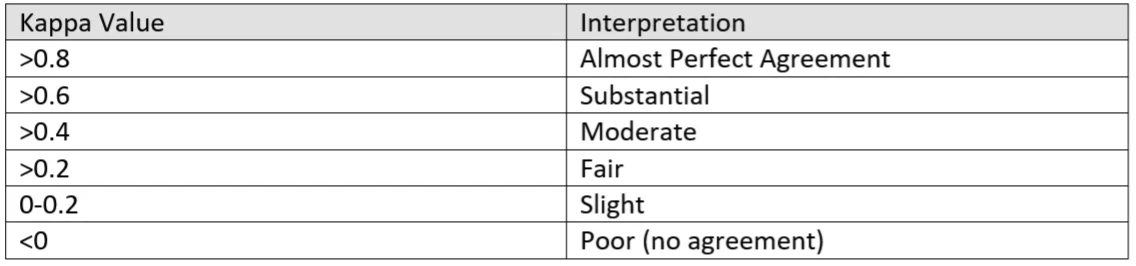

Rather than just calculating the percentage of items that the raters agree on, Cohen’s Kappa account for the fact that the raters may happen to agree on some items purely by chance.

Reasons why Cohen’s Kappa is used and considered acceptable:

· Accounts for Chance Agreement: Cohen’s Kappa corrects for the possibility of agreement occurring by chance alone. This is particularly useful in situations where there may be a high degree of agreement by random chance, especially if the classes are imbalanced.

· Handles Imbalanced Classes: In situations where classes are imbalanced (i.e., one class is much more frequent than others), accuracy alone may not provide an accurate reflection of model performance. Cohen’s Kappa takes into account both the observed agreement and the expected agreement, providing a more balanced measure.

· Works with Categorical Data: Cohen’s Kappa is suitable for evaluating the performance of classification models with categorical outcomes, making it applicable in various domains such as medical diagnosis, natural language processing, and image recognition.

· Interpretability: Cohen’s Kappa provides a score that is interpretable. Values closer to 1 indicate higher agreement beyond chance, while values closer to 0 suggest agreement no better than random chance.

· Robustness: Cohen’s Kappa is robust against class distribution changes. It doesn’t heavily depend on the prevalence of different classes in the dataset.

· Widely Accepted: Cohen’s Kappa is a well-established and widely used metric for assessing inter-rater agreement and classification model performance, making it acceptable in many fields and applications.

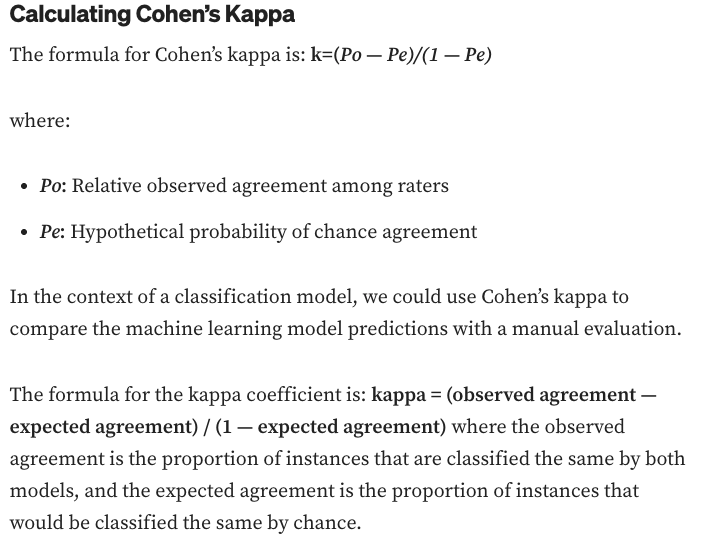

Можемо бачити, що майже всі анотатори проставляли відповідно до 

#### (1.2) Summary of all scores observations

In [23]:
def get_agreement_summary(kappa_results):
    """Get summary statistics for the kappa scores"""
    
    kappa_values = [result for result in kappa_results.values()]
    
    summary = {
        'min_kappa': min(kappa_values),
        'max_kappa': max(kappa_values),
        'mean_kappa': sum(kappa_values) / len(kappa_values),
        'median_kappa': sorted(kappa_values)[len(kappa_values) // 2],
        'num_pairs': len(kappa_values)
    }
    
    # Interpret agreement level based on https://pmc.ncbi.nlm.nih.gov/articles/PMC3900052/#:~:text=Cohen%20suggested%20the%20Kappa%20result,1.00%20as%20almost%20perfect%20agreement.
    
    mean_kappa = summary['mean_kappa']
    if mean_kappa < 0:
        agreement_level = "Poor (less than chance)"
    elif mean_kappa < 0.2:
        agreement_level = "Slight"
    elif mean_kappa < 0.4:
        agreement_level = "Fair"
    elif mean_kappa < 0.6:
        agreement_level = "Moderate"
    elif mean_kappa < 0.8:
        agreement_level = "Substantial"
    else:
        agreement_level = "Almost Perfect"
    
    summary['agreement_level'] = agreement_level
    return summary


In [24]:
get_agreement_summary(kappa_results)

{'min_kappa': np.float64(0.7134537852769898),
 'max_kappa': np.float64(0.8641864634692963),
 'mean_kappa': np.float64(0.792166061383915),
 'median_kappa': np.float64(0.8021696549645925),
 'num_pairs': 10,
 'agreement_level': 'Substantial'}

Hello world!

## 2. Removing doubled annotations to create a clear final dataset with unique pairs of 'document' - 'sentiment'

Let's create an unique identifier for a text in the dataset

In [28]:
df['unique_document_id'] = df.apply(lambda x: str(x['document_id']) + '_' + str(x['is_ck_annotation']), axis = 1) 

In [32]:
df

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O,1_1
1,2,1,1065283664,neutral,1,2025-03-09T23:42:44.339410,⚡️Українська делегація відправилася на перемов...,2025-03-09,A,1_1
2,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A,2_1
3,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A,3_1
4,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A,4_1
...,...,...,...,...,...,...,...,...,...,...
13007,13031,4572,467130971,negative,0,2025-04-04T08:03:48.251166,На Вугледарському напрямку загинув Рома Іванен...,2025-04-04,D,4572_0
13008,13032,6150,277133851,mixed,0,2025-04-04T08:06:11.798354,"На цьому етапі послуга доступна районам, які н...",2025-04-04,O,6150_0
13009,13033,9360,258269671,neutral,0,2025-04-04T20:27:26.671585,@Дія Наше майно знаходиться в місті Херсоні. І...,2025-04-04,V,9360_0
13010,13034,492,1065283664,mixed,0,2025-04-04T20:36:18.575324,"Це не зовсім те що я очікувала, але загалом не...",2025-04-04,A,492_0


In [34]:
documents_cnt = df.groupby('unique_document_id').agg({'response_id': 'count'}).reset_index()

In [37]:
documents_cnt = documents_cnt.rename(columns={'response_id': 'count'})

In [ ]:
documents_cnt = documents_cnt.loc[documents_cnt['count'] > 1]  #we choose all documents which were annotated twice and more by different annotators

In [42]:
documents_cnt['unique_document_id'].unique()

array(['100_1', '101_1', '10_1', '11010_0', '11873_0', '11_1', '12_1',
       '139_0', '13_1', '14_1', '15_1', '1697_0', '16_1', '17_1', '18_1',
       '1923_0', '19_1', '1_1', '20_1', '21_1', '22_1', '23_1', '24_1',
       '25_1', '26_1', '27_1', '28_1', '29_1', '2_1', '30_1', '31_1',
       '32_1', '33_1', '34_1', '3572_0', '3594_0', '35_1', '3652_0',
       '36_1', '37_1', '38_1', '3980_0', '39_1', '3_1', '40_1', '41_1',
       '4228_0', '42_1', '43_1', '44_1', '45_1', '46_1', '4730_0', '47_1',
       '4849_0', '48_1', '492_0', '49_1', '4_1', '50_1', '51_1', '52_1',
       '53_1', '54_1', '55_1', '56_1', '57_1', '58_1', '59_1', '5_1',
       '60_1', '6150_0', '61_1', '62_1', '63_1', '64_1', '65_1', '6628_0',
       '66_1', '67_1', '68_1', '69_1', '6_1', '70_1', '71_1', '72_1',
       '73_1', '7483_0', '74_1', '7574_0', '75_1', '76_1', '7793_0',
       '77_1', '7856_0', '785_0', '78_1', '79_1', '7_1', '80_1', '81_1',
       '82_1', '83_1', '84_1', '85_1', '86_1', '87_1', '88_1', '89_

In [44]:
documents_cnt

,unique_document_id,count
110,100_1,5
221,101_1,5
1110,10_1,5
1122,11010_0,2
2079,11873_0,2
...,...,...
12362,97_1,5
12473,98_1,5
12560,9979_0,2
12584,99_1,5


We will use majority voting approach for texts from Cohen's kappa subset and manual review for other duplicates

In [45]:
df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 1)]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O,1_1
1,2,1,1065283664,neutral,1,2025-03-09T23:42:44.339410,⚡️Українська делегація відправилася на перемов...,2025-03-09,A,1_1
2,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A,2_1
3,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A,3_1
4,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A,4_1
...,...,...,...,...,...,...,...,...,...,...
500,5461,97,441443976,positive,1,2025-03-16T13:09:36.391486,Спасибо за интересный обзор!,2025-03-16,S,97_1
501,5462,98,441443976,neutral,1,2025-03-16T13:09:49.232079,Зеленський підтримав приєднання України до іні...,2025-03-16,S,98_1
502,5463,99,441443976,positive,1,2025-03-16T13:09:55.395889,Ой... в Білгороді зникло світло через пошкодже...,2025-03-16,S,99_1
503,5464,100,441443976,mixed,1,2025-03-16T13:10:02.386874,"Окупований Крим, орки почали копати нові окопи...",2025-03-16,S,100_1


In [88]:
for document in df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 1)]['unique_document_id'].unique():
    major_sentiment = df.loc[df['unique_document_id'] == document].groupby('annotator_sentiment').agg({'response_id': 'count'}).reset_index().sort_values('response_id', ascending=False)['annotator_sentiment'].values[0]
    df.loc[df['unique_document_id'] == document, 'annotator_sentiment'] = major_sentiment

In [107]:
df.loc[df['unique_document_id'] == '1_1', ['document_content']].duplicated()  #let's drop excesive duplicates

0      False
1       True
9       True
303     True
404     True
dtype: bool

In [111]:
filter_array = df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 1), ['unique_document_id']].duplicated()

In [120]:
duplicated_idx = df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 1) & filter_array].index 

In [121]:
df.shape

(13012, 10)

In [123]:
df.drop(duplicated_idx, inplace=True)

In [124]:
df.shape

(12608, 10)

In [125]:
13012-12608

404

In [126]:
df.reset_index(drop=True, inplace=True)

Manual review of remaining duplicates

In [134]:
df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 0)].sort_values('unique_document_id')

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
7873,8285,11010,277133851,neutral,0,2025-03-22T18:01:01.458718,Тут тільки в Епіцентрі можна витратити кешбек ...,2025-03-22,O,11010_0
7491,7903,11010,467130971,neutral,0,2025-03-20T14:03:19.764264,Тут тільки в Епіцентрі можна витратити кешбек ...,2025-03-20,D,11010_0
9371,9799,11873,467130971,neutral,0,2025-03-31T21:19:29.800169,Жилищный сертификат за уничтоженное имущество ...,2025-03-31,D,11873_0
10251,10679,11873,258269671,neutral,0,2025-04-01T22:26:57.034605,Жилищный сертификат за уничтоженное имущество ...,2025-04-01,V,11873_0
4221,4532,139,277133851,positive,0,2025-03-15T21:24:38.992223,Читаю цю книжку своїм дітям 10-ти й 7-ми років...,2025-03-15,O,139_0
4223,4534,139,467130971,positive,0,2025-03-15T21:25:07.861168,Читаю цю книжку своїм дітям 10-ти й 7-ми років...,2025-03-15,D,139_0
9766,10194,1697,467130971,positive,0,2025-04-01T08:38:54.559384,❕Підготовка до передачі ЗРК «Patriot» Україні ...,2025-04-01,D,1697_0
10049,10477,1697,277133851,neutral,0,2025-04-01T21:27:37.509594,❕Підготовка до передачі ЗРК «Patriot» Україні ...,2025-04-01,O,1697_0
8052,8464,1923,1065283664,neutral,0,2025-03-23T20:49:49.728767,❕Нижня палата парламенту Нідерландів визнала р...,2025-03-23,A,1923_0
8055,8467,1923,258269671,neutral,0,2025-03-24T09:24:37.880682,❕Нижня палата парламенту Нідерландів визнала р...,2025-03-24,V,1923_0


In [149]:
# df.loc[3087, 'document_content']
df.loc[10049, 'annotator_sentiment'] = 'positive'   # ❕Підготовка до передачі ЗРК «Patriot» Україні почалась, — глава МЗС України.  «Очікуємо на розгортання Patriot у максимально стислі терміни. Підготовка до передачі цих систем уже розпочалась».  🔥🔥🔥'
df.loc[955, 'annotator_sentiment'] = 'mixed'    #Прапор з Бахмуту 🥺
df.loc[1364, 'annotator_sentiment'] = 'mixed'   #Прапор з Бахмуту 🥺
df.loc[1182, 'annotator_sentiment'] = 'mixed'   #❗️Інформація щодо російсько вторгнення  Тривають аварійно-рятувальні роботи в адмінбудівлях після ранкового ворожого ракетного обстрілу #Харкова. На даний час 10 людей врятовано з-під завалів. Попередньо 4 загиблих, 9 травмовано. На місці працює 21 одиниця техніки ДСНС та 90 чол. особового складу. Роботи тривають.  (Коментар керівника пресслужби ДСНС у Харківській області Євгенія Василенка) #stoprussia'
df.loc[8367, 'annotator_sentiment'] = 'mixed'   #дуже довгий текст з оголошенням Шмигаля 
df.loc[11576, 'annotator_sentiment'] = 'mixed'   #дуже довгий текст з оголошенням Шмигаля 
df.loc[12604, 'annotator_sentiment'] = 'mixed'   # Віримо в ЗСУ й нашу перемогу та чекаємо на повернення рідних територій! Дія Сервіс державних послуг, з яким зручно
df.loc[11726, 'annotator_sentiment'] = 'mixed'   # Віримо в ЗСУ й нашу перемогу та чекаємо на повернення рідних територій! Дія Сервіс державних послуг, з яким зручно
df.loc[8028, 'annotator_sentiment'] = 'mixed'   # На жаль реєстратори з інших областей не матимуть можливості здійснювати будь-які дії з Вашим обєктом нерухомого майна.   З практики, що склалася, причиною непідтягнення є те, що у правовму документі (у реєстрі ДРРП) має місце якась неточність. Наприклад: якось реєстратор не зазначив який вид має обєкт нерухомості: житловий обєкт чи нежитловий. Після виправлення цієї неточності вся інформація підтягнулася.
df.loc[6852, 'annotator_sentiment'] = 'mixed'   # На жаль реєстратори з інших областей не матимуть можливості здійснювати будь-які дії з Вашим обєктом нерухомого майна.   З практики, що склалася, причиною непідтягнення є те, що у правовму документі (у реєстрі ДРРП) має місце якась неточність. Наприклад: якось реєстратор не зазначив який вид має обєкт нерухомості: житловий обєкт чи нежитловий. Після виправлення цієї неточності вся інформація підтягнулася.
df.loc[12457, 'annotator_sentiment'] = 'negative'   #На тебе на ночь. Мільйони на зупинки під час війни. Що не так з павільйонами на Лермонтова? 
df.loc[6112, 'annotator_sentiment'] = 'neutral'   #На пк 2012 года вряд ли есть телеграм)	
df.loc[3087, 'annotator_sentiment'] = 'negative'   #Ждал девочек минут 10. Ходят там по залу друг за другом!
df.loc[3087, 'annotator_sentiment'] = 'negative'   #Ждал девочек минут 10. Ходят там по залу друг за другом!

We can see that most disagreements are related to 'mixed' texts.

Let's remove duplicated texts

In [150]:
df.shape

(12608, 10)

In [154]:
filter_array = df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 0), ['unique_document_id']].duplicated()

In [155]:
duplicated_idx = df.loc[(df['unique_document_id'].isin(documents_cnt['unique_document_id'].unique())) & (df['is_ck_annotation'] == 0) & filter_array].index 

In [157]:
len(filter_array)

44

In [158]:
len(duplicated_idx)

22

In [159]:
df.drop(duplicated_idx, inplace=True)

In [160]:
df.shape

(12586, 10)

In [161]:
df.reset_index(drop=True, inplace=True)

In [219]:
df.unique_document_id.value_counts()

unique_document_id
1_1        1
3414_0     1
9090_0     1
5297_0     1
397_0      1
          ..
4944_0     1
12028_0    1
6725_0     1
3355_0     1
9934_0     1
Name: count, Length: 12313, dtype: int64

#### (2.1) Identifying and removing doubled texts from the dataset

In [ ]:
df['document_content'].duplicated().sum()

np.int64(80)

There are 80 full duplicates

In [171]:
for text in df.loc[df['document_content'].duplicated(), 'document_content'].unique(): 
    pprint.pprint(text, width = 250)

'Вибухи у Запоріжжі.'
'😂😂😂'
'База'
'😍😍😍'
'Харків вибухи'
'Днепр тревога'
'Упс..'
'Вибухи у Херсоні.'
'У Харкові вибухи'
'Вибухи у Харкові'
"Повітряна тривога пов'язана з активністю потенційних носіїв гіперзвукових ракет «Кинджал» — МіГ-31К."
'Днепр тревога ❗️'
'👹👹👹'
'‼️УВАГА! У Вінниці оголошена повітряна тривога!  Просимо всіх терміново прослідувати в укриття цивільного захисту.'
'Спасибо'
'Наш'
'Вибух у Кривому Розі.'
'Вибухи у Києві.'
'Вибух у Запоріжжі.'
'Николаев'
'Отлично'
'Вибухи на Дніпропетровщині.'
'На всякий случай мои соц сети:  Инстаграм Фейсбук Твитер'
'У Чернігові повітряна тривога.'
'Вибух у Харкові.'
'Вибухи у передмісті Харкова.'
'Вибухи у Дніпрі.'
'Робота ППО на Дніпропетровщині.'
'Дніпропетровщина — робота ППО.'
'🤡🤡🤡'
'😂😂😂😂😂😂😂'
'БНР обстановка'
')))'
'👍👍👍❤️'
'Тоже самое'
'Вибухи у Миколаєві.'
'Дякую'
'Дякую!'
'🇺🇦 Кіровоградщина — робота ППО.'
'У Херсоні вибухи'
'👀'
'Бєлгородська область — вибухи.'
'🫡🫡🫡'
'Упс'
('Салют народ! Группа Моджахеда от части является вольно-

We will look through all duplicates and drop unnecessary texts

In [175]:
for id in df.loc[df['document_content'].duplicated(keep=False)].sort_values('document_content').index:
    print(f'{id} Original sentiment: {df.loc[id, 'annotator_sentiment']}')
    print(f'{id} Original annoatator: {df.loc[id, 'username']}')
    pprint.pprint(df.loc[id, 'document_content'], width=250)
    print('--------------------')
    print('--------------------')
    print('--------------------')

9592 Original sentiment: positive
9592 Original annoatator: D
')))'
--------------------
--------------------
--------------------
4282 Original sentiment: positive
4282 Original annoatator: D
')))'
--------------------
--------------------
--------------------
9555 Original sentiment: positive
9555 Original annoatator: D
')))'
--------------------
--------------------
--------------------
9505 Original sentiment: positive
9505 Original annoatator: D
'БНР обстановка'
--------------------
--------------------
--------------------
4751 Original sentiment: neutral
4751 Original annoatator: O
'БНР обстановка'
--------------------
--------------------
--------------------
1443 Original sentiment: positive
1443 Original annoatator: D
'База'
--------------------
--------------------
--------------------
5036 Original sentiment: positive
5036 Original annoatator: O
'База'
--------------------
--------------------
--------------------
7891 Original sentiment: positive
7891 Original annoatator: 

In [ ]:
indeces_to_drop = [9505, 9592, 9555, 5036, 7891, 7921, 2323, 1088, 7105, 6505, 1920, 7859, 6556, 
                   7546, 2960, 10505, 11365, 731, 1893, 9809, 12102, 9452, 4205, 4525, 11828, 6921, 3712, 
                   6576, 2472, 3006, 4329, 7908, 2273, 1823, 3218, 9262, 3940, 6819, 10762, 
                   2061, 4186, 5820, 4587, 7510, 7004, 10955, 8748, 4032, 1188, 15, 3414, 3474, 4429, 
                   12350, 10390, 5387, 3529, 7472, 2656, 11352, 9550, 7769, 2875, 1871,
                   2173, 11597, 10843, 9589, 11397, 7479, 7396, 10928, 1185, 4847, 11424, 892, 7786, 9480,
                   2219, 475, 9195, 11705]

In [187]:
len(indeces_to_drop)

81

In [ ]:
df.drop(indeces_to_drop, inplace=True)

In [ ]:
df.loc[3511, 'annotator_sentiment'] = 'neutral'

In [185]:
df['document_content'].duplicated().sum()

np.int64(0)

In [186]:
df.shape

(12504, 10)

#### (2.2) Removing all 'I don't know'  answers

In [ ]:
df.loc[df['annotator_sentiment'] == 'idk'].sort_values('document_content')

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
8271,8697,2324,258269671,idk,0,2025-03-27T09:25:29.762125,"""Одноклассники"" фиксируют рекордный приток нов...",2025-03-27,V,2324_0
7825,8245,10739,467130971,idk,0,2025-03-21T00:23:23.992457,#RU - First Новости Войны https://t.me/first_p...,2025-03-21,D,10739_0
4224,4541,10629,277133851,idk,0,2025-03-15T21:25:45.322741,#UA - 0564ua https://t.me/krivojrog0564/75729 ...,2025-03-15,O,10629_0
10073,10516,10766,277133851,idk,0,2025-04-01T21:44:57.324702,#UA - 1й Запорожский https://t.me/onenews_zp/5...,2025-04-01,O,10766_0
9388,9830,10976,467130971,idk,0,2025-03-31T21:22:46.057222,#UA - 8NEWS https://t.me/eight_news/17919 |05...,2025-03-31,D,10976_0
...,...,...,...,...,...,...,...,...,...,...
8485,8911,958,258269671,idk,0,2025-03-27T10:53:49.075003,❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️,2025-03-27,V,958_0
12331,12777,5077,467130971,idk,0,2025-04-03T20:56:33.899675,Ⱆ̃ⰽⱃⰰїⱀⰰ-Ⱃⱆⱄⱐ ❤️‍ ⰂⰍⰎⰓⰆ Ҏꙋmⰵⱀⰹ꙼ꙴⱕ ꙮ Ҁⰾⱉⰲⱑⱀ...,2025-04-03,D,5077_0
8007,8429,3599,258269671,idk,0,2025-03-23T15:54:58.713060,👀👀,2025-03-23,V,3599_0
8225,8651,3022,258269671,idk,0,2025-03-27T08:24:34.451879,👹,2025-03-27,V,3022_0


In [190]:
for id in df.loc[df['annotator_sentiment'] == 'idk'].sort_values('document_content').index:
    print(f'{id} Original sentiment: {df.loc[id, 'annotator_sentiment']}')
    print(f'{id} Original annoatator: {df.loc[id, 'username']}')
    pprint.pprint(df.loc[id, 'document_content'], width=250)
    print('--------------------')
    print('--------------------')
    print('--------------------')

8271 Original sentiment: idk
8271 Original annoatator: V
'"Одноклассники" фиксируют рекордный приток новой аудитории, с начала марта рост регистраций пользователей в социальной сети превысил 66%, сообщили в компании.  А аську уже скачали?)'
--------------------
--------------------
--------------------
7825 Original sentiment: idk
7825 Original annoatator: D
('#RU - First Новости Войны https://t.me/first_political/49117  |05/10/23|10:12CET| - - - - - - - В приложении "Дія" заработала функция "єВідновлення" - компенсация за поврежденное жилье. Теперь заявление о нанесенном жилью ущербе можно подать в '
 'приложении, сообщил глава Минцифры Михаил Федоров. В программе участвуют ряд банков, в которых нужно будет открыть специализированный счет "єВідновлення" (работает по тому же принципу, что и программа "єПідтримка"). На первом этапе услуги помощь '
 'получат люди, чьи дома требуют косметического ремонта, например, жилье пригодно для жизни, но нужно заменить окна, двери, отремонтировать к

Firstly, let's mark the sentences to review again and manually define sentiment

In [191]:
indeces_to_review = [8271, 8336, 4034, 8364, 8301, 4331, 8296, 9383, 8333, 8426, 8185, 8305, 8421, 
                     8359, 8470, 8395, 326, 1358, 520, 8197, 8176, 1381, 8068, 11441, 5090, 2544, 1379, 
                     3485, 8465, 8344, 8249, 317, 8255, 8484, 8383, 8325, 8503, 2185, 8500, 105, 8270,
                     8436, 8444, 8250, 8385, 8192, 8860, 8293, 8485, 8225]

In [203]:
def sentiment_corrector(final_df: pd.DataFrame, id: int) -> None:
    
    temp_df = final_df.copy()

    print(f'''Sentiment: {temp_df.loc[id, 'annotator_sentiment']}''')
    print(f'''Author: {temp_df.loc[id, 'username']}''')
    pprint.pprint(f'''Text: {temp_df.loc[id, 'document_content']}''', width=250)    
    
    new_sentiment = input('What is a new sentiment? : ')

    if new_sentiment == 'n':
        print('\nNothing changed')
        print('--------------------------------')
        print('--------------------------------')
    else: 
        print(f'''\n New sentiment: {new_sentiment} at index {id}''')
        final_df.loc[id, 'annotator_sentiment'] = new_sentiment
        print('--------------------------------')
        print('--------------------------------')

In [204]:
df.annotator_sentiment.unique()

array(['neutral', 'negative', 'positive', 'mixed', 'idk'], dtype=object)

In [205]:
for ind in indeces_to_review:
    sentiment_corrector(df, ind)

Sentiment: mixed
Author: V
'Text: "Одноклассники" фиксируют рекордный приток новой аудитории, с начала марта рост регистраций пользователей в социальной сети превысил 66%, сообщили в компании.  А аську уже скачали?)'

Nothing changed
--------------------------------
--------------------------------
Sentiment: neutral
Author: V
'Text: .'

Nothing changed
--------------------------------
--------------------------------
Sentiment: idk
Author: O
'Text: 30к на одну заяву, то небагато'

 New sentiment: neutral at index 4034
--------------------------------
--------------------------------
Sentiment: idk
Author: V
'Text: @diia_support'

 New sentiment: neutral at index 8364
--------------------------------
--------------------------------
Sentiment: idk
Author: V
'Text: А путин не сообразил что его спецом на войну развели ради западных интересов ? Прощиталсьо? Лохонулсьо?'

 New sentiment: negative at index 8301
--------------------------------
--------------------------------
Sentiment: idk

In [207]:
df.loc[8465, 'document_content']

'Смішно читати такі коменти від дорослої людини. У будь-якої держави різні джерела фінансування, зокрема і податки, і міжнародна допомога. Чи ви Америку відкрили? Замість того, щоб радіти, що під час війни держава вишукує можливість допомагати постраждалим від війни, хоча вона ще не закінчилась, ви тут дискусії розводите? Приїдьте до мене в Ірпінь, я вам покажу свою зруйновану квартиру, щоб вам соромно стало.'

In [208]:
df.loc[8465, 'annotator_sentiment'] = 'mixed'

All other IDK labels can be dropped

In [211]:
df.drop(df.loc[df['annotator_sentiment'] == 'idk'].index, inplace=True)

In [213]:
df.reset_index(drop=True, inplace=True)

In [214]:
df.annotator_sentiment.value_counts()

annotator_sentiment
neutral     4735
negative    4571
positive    2399
mixed        608
Name: count, dtype: int64

In [215]:
df.shape

(12313, 10)

Secondly, let's try to find spam messages and simply delete them

'''
Євідновлення❓Опитування. У сотні тисяч громадян України Є розтрощені війною хати-квартири-тощо, і в мене питання: #Зе піздобратія комусь допомогла відбудувати розтрощене⁉Знаю по-собі, бла-бла-бла, шукайте-виправляйте акти-довідкі, '
 'дайте на лапу, ОСЬ-ОСЬ або після Перемоги... Допомогли Тягнуть час У мене все #Зе заїбіся')
 '''


Detected spam message with many occurrences

'''
Мінцифри запускає єВідновлення: подавайте заяву в Дії та отримуйте кошти на ремонт пошкодженого житла. Відтепер українці, чиї домівки постраждали через бойові '
 'дії, можуть подати заяву в Дії та отримати кошти на ремонт за програмою єВідновлення. Максимальна сума — 200 тис.грн. Послуга доступна, якщо житло підлягає відновленню і не було повністю відремонтоване.
 '''

Another spam message

В приложении "Дія" заработала функция "єВідновлення" - компенсация за поврежденное жилье

"єВідновлення в Дії": подати заяву про ремонт пошкодженого житла тепер можна в застосунку. єВідновлення — це грошова допомога від держави на ремонт житла,

У додатку «Дія» відтепер активна послуга «єВідновлення» для виплат за пошкоджене житло

Відтепер в можна подати заявку на ремонт пошкодженого житла

А путин не сообразил что его спецом на войну развели ради западных интересов ? Прощиталсьо? Лохонулсьо?

In [217]:
first_spam = '''Євідновлення❓Опитування. У сотні тисяч громадян України Є розтрощені війною хати-квартири-тощо, і в мене питання: #Зе піздобратія комусь допомогла відбудувати розтрощене⁉Знаю по-собі, бла-бла-бла, шукайте-виправляйте акти-довідкі'''

In [218]:
df.loc[(df['document_content'].str.contains(first_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
484,790,7964,467130971,negative,0,2025-03-10T22:49:18.381690,@NPU_GOV_UA @Onshore_Yolki ℹ Євідновлення❓Опит...,2025-03-10,D,7964_0
497,803,7975,467130971,negative,0,2025-03-10T22:52:10.556184,@01eg08031 ℹ Євідновлення❓Опитування. У сотні ...,2025-03-10,D,7975_0
2409,2748,8016,467130971,negative,0,2025-03-12T22:19:16.103207,@War_Mapper ℹ Євідновлення❓Опитування. У сотні...,2025-03-12,D,8016_0
2522,2867,7992,277133851,negative,0,2025-03-12T22:35:59.290128,@ludmila_ukraine ℹ Євідновлення❓Опитування. У ...,2025-03-12,O,7992_0
2544,2889,8008,277133851,negative,0,2025-03-12T22:38:56.215307,@KHARKIV_RULIT ℹ Євідновлення❓Опитування. У со...,2025-03-12,O,8008_0
2988,3349,7990,467130971,negative,0,2025-03-13T22:50:48.993132,@vitalii_umanets ℹ Євідновлення❓Опитування. У ...,2025-03-13,D,7990_0
3031,3392,8020,258269671,negative,0,2025-03-13T23:10:14.671925,@nazareye ℹ Євідновлення❓Опитування. У сотні т...,2025-03-13,V,8020_0
3111,3474,7987,277133851,negative,0,2025-03-14T00:11:10.423936,@censor_net ℹ Євідновлення❓Опитування. У сотні...,2025-03-14,O,7987_0
3447,3821,7966,467130971,negative,0,2025-03-14T20:13:25.990403,@AndriyYermak ℹ Євідновлення❓Опитування. У сот...,2025-03-14,D,7966_0
3940,4330,7967,277133851,negative,0,2025-03-15T19:28:32.504289,@AnnaSk75324313 ℹ Євідновлення❓Опитування. У с...,2025-03-15,O,7967_0


In [222]:
df.drop(df.loc[(df['document_content'].str.contains(first_spam, case=False)), :].index[1:], inplace=True)

In [223]:
df.loc[(df['document_content'].str.contains(first_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
484,790,7964,467130971,negative,0,2025-03-10T22:49:18.381690,@NPU_GOV_UA @Onshore_Yolki ℹ Євідновлення❓Опит...,2025-03-10,D,7964_0


In [224]:
first_spam = '''#Зе заїбіся'''

In [225]:
df.loc[(df['document_content'].str.contains(first_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
484,790,7964,467130971,negative,0,2025-03-10T22:49:18.381690,@NPU_GOV_UA @Onshore_Yolki ℹ Євідновлення❓Опит...,2025-03-10,D,7964_0


In [226]:
df.loc[(df['document_content'].str.contains('''#Зе''', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
484,790,7964,467130971,negative,0,2025-03-10T22:49:18.381690,@NPU_GOV_UA @Onshore_Yolki ℹ Євідновлення❓Опит...,2025-03-10,D,7964_0


In [229]:
second_spam = '''Максимальна сума — 200 тис.грн'''

In [230]:
df.loc[(df['document_content'].str.contains(second_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
228,451,10769,1065283664,neutral,0,2025-03-10T07:54:40.199852,#UA - Біла Церква - Телеканал Крокус https://t...,2025-03-10,A,10769_0
278,502,10422,258269671,neutral,0,2025-03-10T12:38:36.777978,#UA - Житомирська обласна військова адміністра...,2025-03-10,V,10422_0
945,1254,10750,467130971,positive,0,2025-03-11T14:16:01.750675,#UA - Новгород-Сіверський INFO https://t.me/no...,2025-03-11,D,10750_0
998,1307,10982,467130971,neutral,0,2025-03-11T14:35:43.098236,#UA - dru_news | ДРУЖКОВКА https://t.me/dru_ne...,2025-03-11,D,10982_0
1181,1493,10628,467130971,positive,0,2025-03-11T17:58:08.448942,#UA - LozovaNews https://t.me/lozova_news/1852...,2025-03-11,D,10628_0
1191,1504,10638,258269671,neutral,0,2025-03-11T17:59:08.173754,#UA - ️Херсонська міська рада https://t.me/khe...,2025-03-11,V,10638_0
1509,1823,10992,467130971,positive,0,2025-03-11T21:22:38.148017,#UA - 33 Канал https://t.me/Chennel_33TV/43750...,2025-03-11,D,10992_0
2051,2381,10985,467130971,positive,0,2025-03-12T19:36:04.884535,#UA - ЖОВТОВОДСЬКА МІСЬКА РАДА https://t.me/zh...,2025-03-12,D,10985_0
3781,4164,10978,277133851,positive,0,2025-03-15T10:36:51.680912,#UA - торецьк_info https://t.me/VCAtoretsk_inf...,2025-03-15,O,10978_0
5278,5820,11919,277133851,neutral,0,2025-03-16T19:25:44.573188,В Дії запустили послугу єВідновлення. Відтепер...,2025-03-16,O,11919_0


In [232]:
for id in df.loc[(df['document_content'].str.contains(second_spam, case=False)), :].sort_values('document_content').index:
    print(f'{id} Original sentiment: {df.loc[id, 'annotator_sentiment']}')
    print(f'{id} Original annoatator: {df.loc[id, 'username']}')
    pprint.pprint(df.loc[id, 'document_content'], width=250)
    print('--------------------')
    print('--------------------')
    print('--------------------')

1509 Original sentiment: positive
1509 Original annoatator: D
('#UA - 33 Канал https://t.me/Chennel_33TV/43750  |05/10/23|08:57CET| - - - - - - - єВідновлення в Дії Подавайте заяву про ремонт пошкодженого житла в застосунку. єВідновлення — це грошова допомога від держави на ремонт житла, пошкодженого через '
 'бойові дії. Максимальна сума — 200 тис.грн. Відправити заяву про отримання виплати можна в застосунку Дія Кошти нараховуються, якщо житло: пошкоджене через напад росії після 24 лютого 2022 року. підлягає відновленню. розміщене на неокупованій '
 'території. не було повністю відремонтоване самостійно. На що можна витратити виплату. На будівельні матеріали чи послуги підрядників, які є учасниками програми єВідновлення. Як отримати допомогу 1⃣ Повідомте про пошкоджене майно в застосунку Дія. '
 'Якщо робили це раніше, повторно не потрібно. 2⃣ Відкрийте рахунок єВідновлення. 3⃣ Заповніть заяву через застосунок Дія. Далі з вами зв’яжеться спеціальна комісія, щоб домовитись про огляд ж

In [234]:
df.loc[998, 'annotator_sentiment'] = 'positive'

In [ ]:
df.drop(278, inplace=True)
df.drop(8175, inplace=True)
df.drop(8283, inplace=True)
df.drop(945, inplace=True)
df.drop(8126, inplace=True)
df.drop(10253, inplace=True)
df.drop(3781, inplace=True)
df.drop(1191, inplace=True)
df.drop(5278, inplace=True)
df.drop(9776, inplace=True)
df.drop(5969, inplace=True)
df.drop(7274, inplace=True)
df.drop(10579, inplace=True)
df.drop(6900, inplace=True)

In [243]:
third_spam = '''В приложении "Дія" заработала функция'''

In [244]:
df.loc[(df['document_content'].str.contains(third_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [245]:
fourth_spam = '''"єВідновлення в Дії": подати заяву про ремонт пошкодженого житла тепер можна в застосунку'''

In [246]:
df.loc[(df['document_content'].str.contains(fourth_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [247]:
fourth_spam = '''єВідновлення — це грошова допомога від держави на ремонт житла'''

In [248]:
df.loc[(df['document_content'].str.contains(fourth_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
1509,1823,10992,467130971,positive,0,2025-03-11T21:22:38.148017,#UA - 33 Канал https://t.me/Chennel_33TV/43750...,2025-03-11,D,10992_0
1587,1901,11276,467130971,positive,0,2025-03-11T23:13:08.067680,Українці через «Дію» можуть отримати до 200 ТИ...,2025-03-11,D,11276_0
3640,4022,11409,467130971,neutral,0,2025-03-15T07:25:25.193575,Українці через «Дію» можуть отримати до 200 ТИ...,2025-03-15,D,11409_0
11161,11861,10636,467130971,neutral,0,2025-04-02T21:17:17.819848,#UA - Важливо Тернопільщина https://t.me/terno...,2025-04-02,D,10636_0


In [249]:
for id in df.loc[(df['document_content'].str.contains(fourth_spam, case=False)), :].sort_values('document_content').index:
    print(f'{id} Original sentiment: {df.loc[id, 'annotator_sentiment']}')
    print(f'{id} Original annoatator: {df.loc[id, 'username']}')
    pprint.pprint(df.loc[id, 'document_content'], width=250)
    print('--------------------')
    print('--------------------')
    print('--------------------')

1509 Original sentiment: positive
1509 Original annoatator: D
('#UA - 33 Канал https://t.me/Chennel_33TV/43750  |05/10/23|08:57CET| - - - - - - - єВідновлення в Дії Подавайте заяву про ремонт пошкодженого житла в застосунку. єВідновлення — це грошова допомога від держави на ремонт житла, пошкодженого через '
 'бойові дії. Максимальна сума — 200 тис.грн. Відправити заяву про отримання виплати можна в застосунку Дія Кошти нараховуються, якщо житло: пошкоджене через напад росії після 24 лютого 2022 року. підлягає відновленню. розміщене на неокупованій '
 'території. не було повністю відремонтоване самостійно. На що можна витратити виплату. На будівельні матеріали чи послуги підрядників, які є учасниками програми єВідновлення. Як отримати допомогу 1⃣ Повідомте про пошкоджене майно в застосунку Дія. '
 'Якщо робили це раніше, повторно не потрібно. 2⃣ Відкрийте рахунок єВідновлення. 3⃣ Заповніть заяву через застосунок Дія. Далі з вами зв’яжеться спеціальна комісія, щоб домовитись про огляд ж

In [ ]:
df.drop(1587, inplace=True)
df.drop(11161, inplace=True)
df.drop(1509, inplace=True)

In [256]:
fifth_spam = '''У додатку «Дія» відтепер активна послуга'''

In [257]:
df.loc[(df['document_content'].str.contains(fifth_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [260]:
sixth_spam = '''Відтепер в можна подати заявку на ремонт пошкодженого житла'''

In [ ]:
df.loc[(df['document_content'].str.contains(sixth_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [262]:
seventh_spam = '''А путин не сообразил что его спецом на войну развели'''

In [263]:
df.loc[(df['document_content'].str.contains(seventh_spam, case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
8102,8727,8088,258269671,negative,0,2025-03-27T09:46:45.308993,А путин не сообразил что его спецом на войну р...,2025-03-27,V,8088_0


In [265]:
df.reset_index(drop=True, inplace=True)

In [266]:
df.shape

(12269, 10)

#### (2.3) Data quality improving (removing of personal information, web links to possibly harmful resources)

In [ ]:
# new_path = './data_provided/final_dataset/final_preprocessed_13042025.csv'
# df.to_parquet(new_path)

In [271]:
df

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O,1_1
1,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A,2_1
2,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A,3_1
3,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A,4_1
4,6,5,1065283664,neutral,1,2025-03-09T23:46:38.993496,Добрий день,2025-03-09,A,5_1
...,...,...,...,...,...,...,...,...,...,...
12264,13028,8948,467130971,negative,0,2025-04-04T08:02:37.362562,"Краще ""повинна бути зручнішою, ніж Uber чи Boo...",2025-04-04,D,8948_0
12265,13029,2094,467130971,mixed,0,2025-04-04T08:03:35.792932,Увага! З деяких інтернет джерел шириться інфор...,2025-04-04,D,2094_0
12266,13030,5013,467130971,neutral,0,2025-04-04T08:03:42.008533,"Питання, цей сертифікат можна вже використовув...",2025-04-04,D,5013_0
12267,13031,4572,467130971,negative,0,2025-04-04T08:03:48.251166,На Вугледарському напрямку загинув Рома Іванен...,2025-04-04,D,4572_0


Public group names

In [272]:

df.loc[(df['document_content'].str.contains('Труха', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
207,411,12240,277133851,mixed,0,2025-03-10T07:32:24.651860,❗️ПРОВАЛИВСЯ асфальт через аварію на тепломере...,2025-03-10,O,12240_0
348,654,10729,277133851,neutral,0,2025-03-10T21:15:05.521005,#UA - Труха Київ https://t.me/truehakiyv/4933 ...,2025-03-10,O,10729_0
1028,1340,12433,467130971,negative,0,2025-03-11T14:47:13.650504,❌💡Свєта втекла з Новобіличей. Від ДТЕК ніякої...,2025-03-11,D,12433_0
2520,2873,12428,277133851,positive,0,2025-03-12T22:36:47.135781,Чоловік застряг під теплотрасою в Києві 😳 Все...,2025-03-12,O,12428_0
2603,2959,12473,467130971,negative,0,2025-03-13T08:55:35.644298,Фекалії у сховищі вже прибрали 🤨 А поки не по...,2025-03-13,D,12473_0
2874,3239,9933,467130971,negative,0,2025-03-13T16:32:09.878150,"Ну як хто випустив Труханова? Все ж ті, хто не...",2025-03-13,D,9933_0
4093,4508,12028,467130971,positive,0,2025-03-15T21:21:05.664654,Збудували фізичний захист для енергообʼєктів К...,2025-03-15,D,12028_0
4422,4856,11589,277133851,mixed,0,2025-03-15T22:55:47.535263,❗️На позачерговій сесії Одеської міської ради ...,2025-03-15,O,11589_0
4647,5093,12165,277133851,negative,0,2025-03-15T23:44:34.755910,😱ПРОРИВ труби на Волоській. Тепер на Подолі у...,2025-03-15,O,12165_0
5921,6504,12445,277133851,neutral,0,2025-03-18T07:42:13.296454,😱 Пʼять «швидких» приїхало на ДТП на Повітрофл...,2025-03-18,O,12445_0


Not so many to be a problem

Company names

In [280]:
df.loc[(df['document_content'].str.contains('Сільпо', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
1092,1405,1371,277133851,positive,0,2025-03-11T16:14:13.575704,Все чудово! Дякую Сільпо!Дякую курʼєру Роману!!,2025-03-11,O,1371_0
1341,1658,1537,258269671,negative,0,2025-03-11T19:33:47.256273,Замовила швидку доставку за 59 хвилин за 120 г...,2025-03-11,V,1537_0
1853,2184,711,467130971,negative,0,2025-03-12T07:15:00.539438,"В додатку зазначено що доставка виконана, прот...",2025-03-12,D,711_0
2140,2477,1472,277133851,negative,0,2025-03-12T20:47:57.114409,Не дуже хочеться більше замовляти тістечка в С...,2025-03-12,O,1472_0
2158,2496,634,277133851,negative,0,2025-03-12T20:59:29.469169,"Гнилі овочі поклали, жахливо. В сільпо доставк...",2025-03-12,O,634_0
3143,3520,1208,277133851,positive,0,2025-03-14T00:19:03.291368,"Зібрано дбайливо, якісні продукти. Дякую збира...",2025-03-14,O,1208_0
3557,3949,910,277133851,positive,0,2025-03-14T23:30:58.106409,Дякую персоналу Сільпо. Клієнтоорієнованість н...,2025-03-14,O,910_0
4413,4846,884,467130971,negative,0,2025-03-15T22:54:26.268663,"Я не знала, що мені потрібно самостійно пакув...",2025-03-15,D,884_0
4579,5020,1137,277133851,negative,0,2025-03-15T23:08:30.246307,"Непривітний персонал, прийшов на зону самовино...",2025-03-15,O,1137_0
4795,5243,748,467130971,negative,0,2025-03-16T07:20:24.169284,Мені поклали не весь товар і тільки через добу...,2025-03-16,D,748_0


In [284]:
silpo_mask = df['document_content'].str.contains('Сільпо', case=False)

In [288]:
df.loc[silpo_mask, 'document_content'] = df.loc[silpo_mask, 'document_content'].str.replace('Сільпо', 'Компанії')

In [289]:
df.loc[silpo_mask, 'document_content'] = df.loc[silpo_mask, 'document_content'].str.replace('сільпо', 'компанії')

In [290]:
df.loc[(df['document_content'].str.contains('Сільпо', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [281]:
df.loc[(df['document_content'].str.contains('Якабу', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
700,1008,478,277133851,positive,0,2025-03-11T07:52:49.932837,Дуже задоволена придбанням.\nНайголовніше - ці...,2025-03-11,O,478_0
4348,4778,600,277133851,positive,0,2025-03-15T22:05:30.157788,Дуже задоволена придбанням.\nНайголовніше - ці...,2025-03-15,O,600_0
9908,10625,455,277133851,positive,0,2025-04-01T22:09:33.088691,Дуже задоволена придбанням.\nНайголовніше - ці...,2025-04-01,O,455_0


In [291]:
df.loc[700, 'document_content']

'Дуже задоволена придбанням.\nНайголовніше - ціна, вона просто чудова, як на мене. Гарне оформлення сторінок, листочки приємні на дотик.\nПрацівники магазину дуже оперативно передзвонюють і пропонують найкращі умови купівлі та пересилки книжок. Посилка новою поштою висилається того ж дня та приходить дуже швидко. Загалом, я придбанням дуже задоволена.\nДякую ЯкаБу!\n'

In [292]:
df.loc[4348, 'document_content']

'Дуже задоволена придбанням.\nНайголовніше - ціна, вона просто чудова, як на мене. Вишукана, тверда палітурка і білий папір. Гарне оформлення сторінок, листочки приємні на дотик.\nПрацівники магазину дуже оперативно передзвонюють і пропонують найкращі умови купівлі та пересилки книжок. Посилка новою поштою висилається того ж дня та приходить дуже швидко. Загалом, я придбанням дуже задоволена.\nДякую ЯкаБу!\n'

In [293]:
df.drop([4348, 9908], inplace=True)

In [294]:
df.loc[(df['document_content'].str.contains('Якабу', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
700,1008,478,277133851,positive,0,2025-03-11T07:52:49.932837,Дуже задоволена придбанням.\nНайголовніше - ці...,2025-03-11,O,478_0


In [297]:
df.loc[700, 'document_content'] = df.loc[700, 'document_content'].replace('ЯкаБу', 'магазину')

In [298]:
df.loc[(df['document_content'].str.contains('Якабу', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [299]:
df.reset_index(inplace=True, drop=True)

In [300]:
df.loc[(df['document_content'].str.contains('Yakaboo', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
1769,2099,168,277133851,positive,0,2025-03-12T07:04:42.520952,"Гарна книжка - все зібрано, як треба.\nЩо до с...",2025-03-12,O,168_0
6743,7356,161,467130971,positive,0,2025-03-19T20:42:21.514407,Неймовірна книжка для ринку україномовної книг...,2025-03-19,D,161_0
7436,8070,376,467130971,positive,0,2025-03-20T21:10:17.285921,"Чудова книга! Цікава, життєва!\nЗамовлення отр...",2025-03-20,D,376_0
8427,9095,443,277133851,positive,0,2025-03-27T19:22:52.364076,Книжка супер! всім шанувальникам Warhammer обо...,2025-03-27,O,443_0
10951,11691,280,467130971,positive,0,2025-04-02T20:39:09.779899,Книга СУПЕРСЬКА!!! ЦІКАВА - КЛАСИКА!\nЩо до се...,2025-04-02,D,280_0


In [301]:
yakaboo_mask = df['document_content'].str.contains('Yakaboo', case=False)

In [302]:
df.loc[yakaboo_mask, 'document_content'] = df.loc[yakaboo_mask, 'document_content'].str.replace('Yakaboo', 'магазину')

In [303]:
df.loc[yakaboo_mask, 'document_content'] = df.loc[yakaboo_mask, 'document_content'].str.replace('yakaboo', 'магазину')

In [304]:
df.loc[(df['document_content'].str.contains('Yakaboo', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id


In [283]:
df.loc[(df['document_content'].str.contains('книга', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
193,397,12178,277133851,neutral,0,2025-03-10T07:28:52.144146,Согласуется ли с наукой сообщение из книги Быт...,2025-03-10,O,12178_0
197,401,532,277133851,positive,0,2025-03-10T07:30:06.137625,"Цікава книга, яка описує життя простої сім'ї, ...",2025-03-10,O,532_0
212,416,164,277133851,positive,0,2025-03-10T07:33:25.128865,Книга потрібна для работи та навчання молодшо...,2025-03-10,O,164_0
433,739,235,277133851,positive,0,2025-03-10T21:27:59.889549,Ліна Костенко з великою точністю описує події ...,2025-03-10,O,235_0
478,785,151,277133851,positive,0,2025-03-10T22:48:05.042675,Супер-книга від супер-авторки.... Чудове оформ...,2025-03-10,O,151_0
...,...,...,...,...,...,...,...,...,...,...
11988,12746,214,467130971,positive,0,2025-04-03T20:51:41.736003,"Чудова книга, треба знати своїх героїв, бо на ...",2025-04-03,D,214_0
12014,12772,436,467130971,positive,0,2025-04-03T20:55:06.520310,Цікава й захоплююча книга для дівчат. Побільше...,2025-04-03,D,436_0
12086,12846,542,467130971,mixed,0,2025-04-03T21:16:01.996253,"Мені вже давно не траплялась книга, яку настіл...",2025-04-03,D,542_0
12111,12871,453,467130971,positive,0,2025-04-03T21:20:44.275108,Книга дуже хороша. Прочитала дуже швидко! Книг...,2025-04-03,D,453_0


In [305]:
df.shape

(12267, 10)

In [306]:
df.reset_index(inplace=True, drop=True)

In [307]:
df

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O,1_1
1,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A,2_1
2,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A,3_1
3,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A,4_1
4,6,5,1065283664,neutral,1,2025-03-09T23:46:38.993496,Добрий день,2025-03-09,A,5_1
...,...,...,...,...,...,...,...,...,...,...
12262,13028,8948,467130971,negative,0,2025-04-04T08:02:37.362562,"Краще ""повинна бути зручнішою, ніж Uber чи Boo...",2025-04-04,D,8948_0
12263,13029,2094,467130971,mixed,0,2025-04-04T08:03:35.792932,Увага! З деяких інтернет джерел шириться інфор...,2025-04-04,D,2094_0
12264,13030,5013,467130971,neutral,0,2025-04-04T08:03:42.008533,"Питання, цей сертифікат можна вже використовув...",2025-04-04,D,5013_0
12265,13031,4572,467130971,negative,0,2025-04-04T08:03:48.251166,На Вугледарському напрямку загинув Рома Іванен...,2025-04-04,D,4572_0


## 3. Exploratory data analysis of the resulted dataset

In [ ]:
# new_path = './data_provided/final_dataset/final_preprocessed_13042025.csv'
# df.to_parquet(new_path)

In [312]:
df

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O,1_1
1,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A,2_1
2,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A,3_1
3,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A,4_1
4,6,5,1065283664,neutral,1,2025-03-09T23:46:38.993496,Добрий день,2025-03-09,A,5_1
...,...,...,...,...,...,...,...,...,...,...
12262,13028,8948,467130971,negative,0,2025-04-04T08:02:37.362562,"Краще ""повинна бути зручнішою, ніж Uber чи Boo...",2025-04-04,D,8948_0
12263,13029,2094,467130971,mixed,0,2025-04-04T08:03:35.792932,Увага! З деяких інтернет джерел шириться інфор...,2025-04-04,D,2094_0
12264,13030,5013,467130971,neutral,0,2025-04-04T08:03:42.008533,"Питання, цей сертифікат можна вже використовув...",2025-04-04,D,5013_0
12265,13031,4572,467130971,negative,0,2025-04-04T08:03:48.251166,На Вугледарському напрямку загинув Рома Іванен...,2025-04-04,D,4572_0


In [313]:
df['document_length'] = df['document_content'].apply(len)

In [315]:
df['document_length'].describe()

count    12267.000000
mean       172.338795
std        247.752764
min          1.000000
25%         44.000000
50%         96.000000
75%        205.000000
max       5749.000000
Name: document_length, dtype: float64

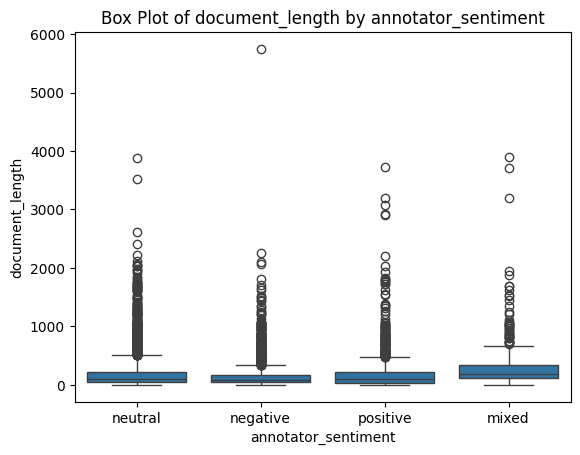

In [317]:
create_boxplot(df, 'document_length', 'annotator_sentiment')

**А СКІЛЬКИ ВЗАГАЛІ ПОВІДОМЛЕНЬ ВІД ТОТАЛА МІСТЯТЬ СЛОВО ЖИТЛО?**

**А СКІЛЬКИ ВЗАГАЛІ ПОВІДОМЛЕНЬ ВІД ТОТАЛА МІСТЯТЬ СЛОВО єВідновленя? - lower**

**Найбільша проблема датасету - це єВідновлення... дуже багато про нього і потрібно буде виправляти якось цей баланс**

In [ ]:
df.loc[(df['document_content'].str.contains('єВідновлення', case=False)), :]

,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id
100,151,11629,258269671,neutral,0,2025-03-10T00:02:21.108129,допомогу юристів http://surl.li/hdmob ✅Як ві...,2025-03-10,V,11629_0
102,153,11631,258269671,neutral,0,2025-03-10T00:02:37.990601,Відсьогодні в Україні стартувала програма «єВі...,2025-03-10,V,11631_0
106,173,10971,258269671,neutral,0,2025-03-10T00:08:35.190759,#UA - Новини Чернігівщини https://t.me/newchne...,2025-03-10,V,10971_0
137,241,11501,1065283664,neutral,0,2025-03-10T00:38:50.988794,В Ізюмі починає працювати програма компенсації...,2025-03-10,A,11501_0
145,249,11509,1065283664,neutral,0,2025-03-10T00:41:23.849537,Доброго дня. Не можу подати заявку на євідновл...,2025-03-10,A,11509_0
...,...,...,...,...,...,...,...,...,...,...
12220,12984,11928,467130971,negative,0,2025-04-04T07:54:49.764614,"Вчора ніч в Одесі була неспокійною. На жаль, в...",2025-04-04,D,11928_0
12225,12989,7939,467130971,mixed,0,2025-04-04T07:55:36.305679,"@adagamov Прошу про допомогу.Мій дім навпроти,...",2025-04-04,D,7939_0
12227,12991,5930,467130971,negative,0,2025-04-04T07:55:55.631593,Розумію так. За неявку без поважної причини по...,2025-04-04,D,5930_0
12244,13008,11410,467130971,neutral,0,2025-04-04T07:58:55.987643,фізичне та ментальне відновлення 3️⃣Економічна...,2025-04-04,D,11410_0


Приклад для ЛЛМ по суржику: 
'Воощето ми на черзі стоїмо з 2020 року з народження дитини!!'

## Other

In [18]:
test_set_n = 930

In [24]:
930*0.05

46.5

In [26]:
test_set_sampling_stat = {

'neutral': 353,
'negative': 317,
'positive': 186,
'mixed': 47

}

In [35]:
# test_sample_document_id = {}
test_sample_document_id = pd.DataFrame(columns=['document_id'])

for label, n_size in test_set_sampling_stat.items():
    # test_sample_document_id[label] = df.loc[(df['annotator_response'] == label), 'document_id'].sample(n=n_size).values
    test_sample_document_id = pd.concat([test_sample_document_id, df.loc[(df['annotator_response'] == label), ['document_id']].sample(n=n_size)])

In [40]:
test_sample_document_id.drop(test_sample_document_id.loc[test_sample_document_id.duplicated()].index, inplace=True)

In [42]:
test_sample_document_id['document_is_in_test_set'] = 1

In [45]:
df = df.merge(test_sample_document_id, how='left', on='document_id')

In [47]:
df['document_is_in_test_set'].fillna(0, inplace=True)

/var/folders/03/kpd_d3r93rx5c9753m1sv1lh0000gn/T/ipykernel_68539/2170965518.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['document_is_in_test_set'].fillna(0, inplace=True)


In [52]:
df.document_is_in_test_set = df.document_is_in_test_set.astype(int)

In [58]:
df.to_csv('./data_provided/final_dataset/ua_sentiment_dataset_with_test.csv', index=False)

In [64]:
df.columns

Index(['response_id', 'document_id', 'user_id', 'annotator_response',
       'is_ck_annotation', 'response_timestamp', 'document_content',
       'is_annotated', 'document_is_in_test_set'],
      dtype='object')

In [20]:
df.annotator_response.value_counts() / df.shape[0]

annotator_response
neutral     0.380722
negative    0.349596
positive    0.192784
mixed       0.049973
idk         0.026925
Name: count, dtype: float64

In [66]:
df

,response_id,document_id,user_id,annotator_response,is_ck_annotation,response_timestamp,document_content,is_annotated,document_is_in_test_set
0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,Шикарное издание для деток до 3-х-4-х лет! Моя...,1,0
1,2,1,1065283664,positive,1,2025-03-09T23:42:44.339410,Шикарное издание для деток до 3-х-4-х лет! Моя...,1,0
2,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Приобрела две книги, одну себе (в коллекцию), ...",1,0
3,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,Шикарная книжка в отличном издании. Рекомендую...,1,0
4,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Качественный блокнот и интересными оригинальны...,1,1
...,...,...,...,...,...,...,...,...,...
9280,9281,2060,277133851,negative,0,2025-03-27T20:20:39.457849,"росія країна мразь, гній, непотріб",1,0
9281,9282,3507,277133851,neutral,0,2025-03-27T20:20:41.700409,Чути вибухи в Кременчуці,1,0
9282,9283,1314,277133851,negative,0,2025-03-27T20:20:47.394075,Пробили у чеку коржі вафельні- і не привезли,1,1
9283,9284,12491,277133851,neutral,0,2025-03-27T20:22:53.777987,Тунель між «Либідською» та «Деміївською» повні...,1,0


In [75]:
df = df.loc[df['user_id'] != 273232876].copy()

### Cohen's Kappa

In [76]:
def calculate_cohens_kappa_for_all_annotators(df):
    """
    Calculate Cohen's Kappa coefficient between all pairs of annotators.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing annotations with 'user_id', 
                           'document_id', and 'annotator_response' columns.
    
    Returns:
    dict: Kappa scores for each pair of annotators
    pd.DataFrame: Matrix of kappa scores
    dict: Summary statistics
    """
    # Step 1: Find documents with multiple annotators
    doc_annotator_counts = df.groupby('document_id')['user_id'].nunique()
    multi_annotator_docs = doc_annotator_counts[doc_annotator_counts > 1].index
    
    # Filter to only include documents with multiple annotators
    filtered_df = df[df['document_id'].isin(multi_annotator_docs)]
    
    # Get unique annotators
    annotators = filtered_df['user_id'].unique()
    print(f"Found {len(annotators)} unique annotators and {len(multi_annotator_docs)} documents with multiple annotations")
    
    # Dictionary to store kappa results
    kappa_results = {}
    
    # Calculate kappa for each pair of annotators
    for annotator1, annotator2 in itertools.combinations(annotators, 2):
        # Get annotations from each annotator
        ann1_data = filtered_df[filtered_df['user_id'] == annotator1][['document_id', 'annotator_response']]
        ann2_data = filtered_df[filtered_df['user_id'] == annotator2][['document_id', 'annotator_response']]
        
        # Find common documents
        common_docs = set(ann1_data['document_id']) & set(ann2_data['document_id'])
        
        if common_docs:
            # Align annotations by document_id
            merged_data = pd.merge(
                ann1_data[ann1_data['document_id'].isin(common_docs)],
                ann2_data[ann2_data['document_id'].isin(common_docs)],
                on='document_id',
                suffixes=('_ann1', '_ann2')
            )
            
            # Drop any rows with missing values
            merged_data = merged_data.dropna(subset=['annotator_response_ann1', 'annotator_response_ann2'])
            
            if len(merged_data) > 0:
                # Calculate Cohen's Kappa
                kappa = cohen_kappa_score(
                    merged_data['annotator_response_ann1'],
                    merged_data['annotator_response_ann2']
                )
                
                kappa_results[(annotator1, annotator2)] = {
                    'kappa': kappa,
                    'num_common_docs': len(merged_data)
                }
    
    # Create a matrix of kappa scores
    kappa_matrix = create_kappa_matrix(kappa_results, annotators)
    
    # Get summary statistics
    summary = get_agreement_summary(kappa_results)
    
    return kappa_results, kappa_matrix, summary



def create_kappa_matrix(kappa_results, annotators):
    """Create a matrix of kappa scores between all annotators"""
    n = len(annotators)
    matrix = np.zeros((n, n))
    
    # Map annotators to indices
    annotator_to_idx = {annotator: i for i, annotator in enumerate(annotators)}
    
    # Fill the matrix
    for (ann1, ann2), result in kappa_results.items():
        i, j = annotator_to_idx[ann1], annotator_to_idx[ann2]
        matrix[i, j] = result['kappa']
        matrix[j, i] = result['kappa']  # Mirror the matrix
    
    # Perfect agreement with self
    np.fill_diagonal(matrix, 1.0)
    
    # Convert to DataFrame for better display
    return pd.DataFrame(matrix, index=annotators, columns=annotators)



def get_agreement_summary(kappa_results):
    """Get summary statistics for the kappa scores"""
    if not kappa_results:
        return {"error": "No valid annotator pairs found"}
    
    kappa_values = [result['kappa'] for result in kappa_results.values()]
    
    summary = {
        'min_kappa': min(kappa_values),
        'max_kappa': max(kappa_values),
        'mean_kappa': sum(kappa_values) / len(kappa_values),
        'median_kappa': sorted(kappa_values)[len(kappa_values) // 2],
        'num_pairs': len(kappa_values)
    }
    
    # Interpret agreement level based on Landis & Koch (1977)
    mean_kappa = summary['mean_kappa']
    if mean_kappa < 0:
        agreement_level = "Poor (less than chance)"
    elif mean_kappa < 0.2:
        agreement_level = "Slight"
    elif mean_kappa < 0.4:
        agreement_level = "Fair"
    elif mean_kappa < 0.6:
        agreement_level = "Moderate"
    elif mean_kappa < 0.8:
        agreement_level = "Substantial"
    else:
        agreement_level = "Almost Perfect"
    
    summary['agreement_level'] = agreement_level
    return summary




# Example usage:
# results, matrix, summary = calculate_cohens_kappa_for_all_annotators(df)
# print("\nOverall agreement level:", summary['agreement_level'])
# plot_kappa_heatmap(matrix)

In [77]:
def plot_kappa_heatmap(kappa_df):
    """Plot a heatmap of kappa scores"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(kappa_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Cohen's Kappa Inter-Annotator Agreement")
    plt.tight_layout()
    plt.show()

In [78]:
results, matrix, summary = calculate_cohens_kappa_for_all_annotators(df)

Found 5 unique annotators and 112 documents with multiple annotations


In [81]:
print("\nOverall agreement level:", summary['agreement_level'], cohen_kappa_mean)


Overall agreement level: Moderate 0.73


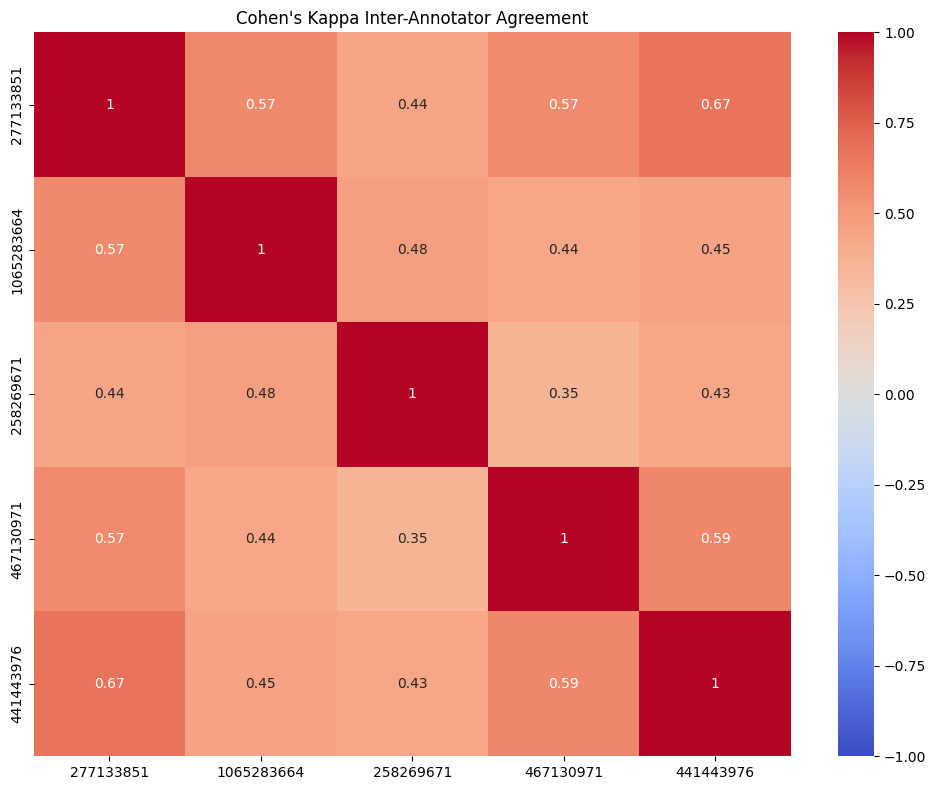

In [82]:
plot_kappa_heatmap(matrix)

## System prompt creation

In [59]:
system_prompt = '''

You are a Ukrainian professional social network analyst. You need to analyze peoples emotions and define the comments sentiment from the Ukrainian social media. The input you receive is a text from Telegram messenger. The text can be Ukrainian or Russian. 

Your output must be a single word from the following list: ['positive', 'neutral', 'negative']. 
Here are some examples of inputs to you and your outputs expected:

```
Input: 'Киеве продолжать звучать взрывы. СМИ сообщают, что в ряде районов пропал свет.'
Output: 'negative'

Input: 'Через обстріли у Києві знеструмлено майже 260 тисяч споживачів, відключалося обладнання підстанцій у Київській області, — Міненерго   У Києві пошкоджено повітряну лінію, без напруги низка підстанцій – знеструмлені 259 тисяч точок обліку.'
Output: 'negative'

Input: 'Попередній висновок🧐  Перше. У нас найкраще в світі ППО! Жодна країна не витримала б такої масованої атаки. Досвід і наявність засобів вберігають 99% населення  Друге. Русня просто вчергове хоче нас залякати, але минулої зими і в травні ми чітко вивчили алгоритми безпеки і хєр кладем русакам на воротнік  Третє. Не бійтеся, скоро і вода і електрика повернуться, а воля наша не зламається!  Інформує Київ | Надіслати новину'
Output: 'positive'

Input: 'Голосеевский р-н есть свет 😉✌🏻'
Output: 'positive'

Input: 'Підкажіть, будь ласка, чи бувають на Видубичах на платформах міської і приміських електричок?'
Output: 'neutral'
```

Remember that the 'sentiment' values can be only and only from the following list: ['positive', 'neutral', 'negative']. 

'''

In [60]:
print(len(system_prompt)/4)

391.25


## Pipeline

https://platform.openai.com/docs/api-reference/authentication

In [ ]:
# "model": "gpt-3.5-turbo",

In [ ]:
api_key = 'sk-proj-7yyg4KC696T7WK6CmLeWT3BlbkFJfjiC6bs5r8R7yoGLCIUP'

In [96]:
client = OpenAI(api_key=api_key)

In [100]:
def analyze_sentiment(comment):
    """
    Sends a request to OpenAI's GPT model to analyze sentiment.
    """
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": comment}
        ]
    )   
    return response.choices[0].message.content

In [101]:
example_comment = 'У деяких районах Києва зникло світло.'

In [102]:
sentiment_result = analyze_sentiment(example_comment)

In [103]:
print("Sentiment Analysis Result:", sentiment_result)

Sentiment Analysis Result: 'negative'


In [104]:
gpt_answers = []

for id in df.index:
    gpt_answers.append(analyze_sentiment(df.loc[id, 'content']))

In [105]:
df['gpt_labels'] = gpt_answers

In [107]:
df['gpt_labels'].value_counts()

gpt_labels
'negative'    253
'positive'    128
'neutral'     123
negative       44
neutral         8
positive        7
Name: count, dtype: int64

In [111]:
df.loc[df['gpt_labels'] == "'negative'", 'gpt_labels'] = 'negative'
df.loc[df['gpt_labels'] == "'positive'", 'gpt_labels'] = 'positive'
df.loc[df['gpt_labels'] == "'neutral'", 'gpt_labels'] = 'neutral'

In [112]:
df['gpt_labels'].value_counts()

gpt_labels
negative    297
positive    135
neutral     131
Name: count, dtype: int64

In [113]:
df['label'].value_counts()

label
Negative    323
Positive    169
Neutral      71
Name: count, dtype: int64

In [ ]:
df['y'] = df['label'].apply(lambda x: {'Negative': -1, 'Neutral': 0, 'Positive': 1}[x])

In [ ]:
df['y_hat'] = df['gpt_labels'].apply(lambda x: {'negative': -1, 'neutral': 0, 'positive': 1}[x])

In [ ]:
df

,content,label,gpt_labels,y,y_hat
1,Шо по відключень енергії в Києві,Negative,neutral,-1,0
2,Збудували фізичний захист для енергообʼєктів К...,Positive,positive,1,1
3,"Так я ж тебе задал вопрос. Киев, май, первое п...",Positive,positive,1,1
4,Аварії,Negative,negative,-1,-1
5,"У вас давно вже щось відпадає,а ви ще до цих п...",Negative,negative,-1,-1
...,...,...,...,...,...
559,‼️Київ. Запрошуємо до співпраці у велику компа...,Positive,positive,1,1
560,Я не я і хата метро не моє. Десь таке загальне...,Negative,negative,-1,-1
561,У меня соседа в начале января приняли на Троещ...,Neutral,neutral,0,0
562,Обґрунтований тариф на проїзд у Київському мет...,Negative,negative,-1,-1


## Metrics

In [136]:
def evaluate_gpt_results(df):
    """
    Computes accuracy and F1-score for GPT sentiment analysis results.
    
    Parameters:
    df (pd.DataFrame): A DataFrame containing 'true_label' and 'gpt_label'.
    
    Returns:
    dict: A dictionary with accuracy and F1-score.
    """
    accuracy = accuracy_score(df['y'], df['y_hat'])
    f1 = f1_score(df['y'], df['y_hat'], average='weighted')
    
    return {"accuracy": round(accuracy, 4), "f1_score": round(f1, 4)}

In [137]:
metrics = evaluate_gpt_results(df)

In [138]:
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'accuracy': 0.7798, 'f1_score': 0.7985}
